# End-to-End Multi-Model Pipeline — Train / Validate / Test
## 70 / 15 / 15 Split — Final Evaluation on Unseen Test Set

**Pipeline**:  
```
Raw CIR → Stage 1 (PI-HLNN: LOS/NLOS?) → Stage 2 (RF: Single/Multi bounce?) → Stage 3 (RF: Predict bias) → d_corrected
```

**Split**: 70% Train / 15% Validation / 15% Test (matching Xu Xueli 2024)  
**Test set**: Completely unseen — never used during training or hyperparameter tuning  

| Stage | Model | Features | Output |
|-------|-------|----------|--------|
| 1 | PI-HLNN (Liquid Neural Network) | Raw 60-sample CIR window | LOS (0) / NLOS (1) |
| 2 | Random Forest Classifier | 64-dim LNN embeddings (frozen Stage 1 PI-HLNN encoder) | Single-bounce (0) / Multi-bounce (1) |
| 3 | Random Forest Regressor | 64-dim LNN embeddings (frozen Stage 1 PI-HLNN encoder) | NLOS bias (meters) |

In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
import joblib
from scipy.signal import find_peaks
from scipy.stats import kurtosis as scipy_kurtosis
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, r2_score,
    mean_absolute_error, mean_squared_error
)
from torch.utils.data import DataLoader, TensorDataset

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


---
## Section 1: Data Loading & 70/15/15 Split

Stratified split ensuring LOS/NLOS ratio preserved in all 3 sets.

In [16]:

# ==========================================
# GROUND TRUTH
# Keys = Source_File prefix (= reflector→RX, laser-measured)
# d_direct = true TX→RX (computed geometrically from floor plan)
# bias = d_bounce − d_direct (NLOS ranging error)
# ==========================================
GROUND_TRUTH = {
    '7.79m':  {'d_direct': 8.81887, 'd_bounce': 12.79, 'bias': 3.97},   # 12.79 − 8.81887
    '10.77m': {'d_direct': 7.20139, 'd_bounce': 16.09, 'bias': 8.89},   # 16.09 − 7.20139
    '14m':    {'d_direct': 14.00,   'd_bounce': 16.80, 'bias': 2.80},   # placeholder d_direct
}

def get_distance_group(fname):
    match = re.match(r'^([\d.]+m)', str(fname))
    return match.group(1) if match else None

# ==========================================
# LOAD FULL DATASET
# ==========================================
df = pd.read_csv('../dataset/channels/combined_uwb_dataset.csv')
print(f'Total samples: {len(df)}')
print(f'  LOS:  {(df["Label"]==0).sum()}')
print(f'  NLOS: {(df["Label"]==1).sum()}')

# ==========================================
# 70 / 15 / 15 STRATIFIED SPLIT
# ==========================================
train_df, temp_df = train_test_split(
    df, test_size=0.30, random_state=SEED, stratify=df['Label']
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=SEED, stratify=temp_df['Label']
)

train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

print(f'\nSplit Results:')
print(f'  Train: {len(train_df)} ({100*len(train_df)/len(df):.1f}%) — LOS={int((train_df["Label"]==0).sum())}, NLOS={int((train_df["Label"]==1).sum())}')
print(f'  Val:   {len(val_df)} ({100*len(val_df)/len(df):.1f}%) — LOS={int((val_df["Label"]==0).sum())}, NLOS={int((val_df["Label"]==1).sum())}')
print(f'  Test:  {len(test_df)} ({100*len(test_df)/len(df):.1f}%) — LOS={int((test_df["Label"]==0).sum())}, NLOS={int((test_df["Label"]==1).sum())}')


Total samples: 3600
  LOS:  1800
  NLOS: 1800

Split Results:
  Train: 2520 (70.0%) — LOS=1260, NLOS=1260
  Val:   540 (15.0%) — LOS=270, NLOS=270
  Test:  540 (15.0%) — LOS=270, NLOS=270


---
## Section 2: Shared Preprocessing & Feature Extraction

Functions shared by all 3 stages.

In [17]:
CIR_COLS = sorted(
    [c for c in df.columns if c.startswith('CIR')],
    key=lambda x: int(x.replace('CIR', ''))
)

# ==========================================
# ROI ALIGNMENT (shared)
# ==========================================
def get_roi_alignment(sig, search_start=740, search_end=890):
    region = sig[search_start:search_end]
    if len(region) == 0:
        return np.argmax(sig)
    peak_local = np.argmax(region)
    peak_idx   = search_start + peak_local
    peak_val   = sig[peak_idx]
    noise_section = sig[:search_start]
    if len(noise_section) > 10:
        noise_mean = np.mean(noise_section)
        noise_std  = np.std(noise_section)
        threshold  = max(noise_mean + 3 * noise_std, 0.05 * peak_val)
    else:
        threshold = 0.05 * peak_val
    leading_edge = peak_idx
    for i in range(peak_idx, max(search_start - 20, 0), -1):
        if sig[i] < threshold:
            leading_edge = i + 1
            break
    return leading_edge


# ==========================================
# STAGE 1 PREPROCESSING: Raw CIR → 60-sample window
# ==========================================
S1_CONFIG = {
    'pre_crop': 10, 'post_crop': 50, 'total_len': 60,
    'search_start': 740, 'search_end': 890,
    'hidden_size': 32,        # per circuit; total embedding = 64 (2 × 32)
    'input_size': 1, 'dropout': 0.2, 'ode_unfolds': 6,
    'batch_size': 64, 'max_epochs': 40, 'lr': 1e-3,
    'weight_decay': 1e-4, 'warmup_epochs': 3,
    'patience': 10, 'grad_clip': 1.0,
}

EMBEDDING_DIM = S1_CONFIG['hidden_size'] * 2  # 64 (two 32-dim circuits concatenated)

def preprocess_stage1(data_df):
    """Convert DataFrame to Stage 1 input: (N, 60, 1) CIR windows."""
    PRE, TOTAL = S1_CONFIG['pre_crop'], S1_CONFIG['total_len']
    seqs, labels = [], []
    for _, row in data_df.iterrows():
        sig = pd.to_numeric(row[CIR_COLS], errors='coerce').fillna(0).astype(float).values
        rxpacc = float(row.get('RXPACC', row.get('RX_PACC', 128.0)))
        if rxpacc > 0:
            sig = sig / rxpacc
        le = get_roi_alignment(sig)
        start = max(0, le - PRE)
        end   = start + TOTAL
        if end > len(sig):
            end   = len(sig)
            start = max(0, end - TOTAL)
        crop = sig[start:end]
        if len(crop) < TOTAL:
            crop = np.pad(crop, (0, TOTAL - len(crop)), mode='constant')
        local_min, local_max = np.min(crop), np.max(crop)
        rng  = local_max - local_min
        crop = (crop - local_min) / rng if rng > 0 else np.zeros(TOTAL)
        seqs.append(crop)
        labels.append(float(row['Label']))
    X = np.array(seqs).reshape(-1, TOTAL, 1).astype(np.float32)
    y = np.array(labels).astype(np.float32)
    return X, y


# ==========================================
# EMBEDDING EXTRACTION (Stages 2 & 3)
# Uses DualCircuit_PI_HLNN.embed() → 64-dim attention-pooled fused state
# ==========================================
EMBEDDING_NAMES = [f'LNN_h{i}' for i in range(EMBEDDING_DIM)]

def extract_lnn_embeddings(model, data_df, batch_size=256):
    """Extract 64-dim fused embeddings from frozen DualCircuit_PI_HLNN encoder."""
    X, _ = preprocess_stage1(data_df)
    X_tensor = torch.tensor(X).to(device)
    all_embeddings = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(X_tensor), batch_size):
            batch = X_tensor[i:i+batch_size]
            emb = model.embed(batch)   # (batch, 64)
            all_embeddings.append(emb.cpu().numpy())
    return np.vstack(all_embeddings)


# ==========================================
# STAGE 2: Bounce classification using ground-truth bounce separation
#
# bounce_sep = bounce_path_idx − los_path_idx  (CIR index units, ~0.3003 m/idx)
# Empirical values per scenario:
#   14m   scenario: bounce_sep ≈  9.3 idx (2.80 m bias) → short bounce (0)
#   7.79m scenario: bounce_sep ≈ 13.2 idx (3.97 m bias) → short bounce (0)
#   10.77m scenario: bounce_sep ≈ 29.6 idx (8.89 m bias) → long  bounce (1)
#
# Threshold at 21.4 idx = midpoint between 13.2 and 29.6
# Short bounce (0): small bias scenarios (14m + 7.79m)
# Long  bounce (1): large bias scenario  (10.77m)
# ==========================================
BOUNCE_SEP_THRESHOLD = 21.4   # CIR index units

def get_bounce_labels(nlos_df):
    """Stage 2 ground-truth labels from geometry-derived bounce separation."""
    bounce_sep = nlos_df['bounce_path_idx'] - nlos_df['los_path_idx']
    return (bounce_sep > BOUNCE_SEP_THRESHOLD).astype(float).values   # 0=short, 1=long

def get_nlos_info(nlos_df):
    """Extract per-row NLOS metadata: source files, UWB distances, ground-truth biases."""
    source_files = nlos_df['Source_File'].tolist()
    distances    = nlos_df['Distance'].tolist()          # UWB-reported range
    biases       = (nlos_df['d_bounce'] - nlos_df['d_direct']).tolist()  # per-row GT bias
    d_directs    = nlos_df['d_direct'].tolist()
    d_bounces    = nlos_df['d_bounce'].tolist()
    return source_files, distances, biases, d_directs, d_bounces


print('Preprocessing functions defined.')
print(f'CIR columns: {len(CIR_COLS)}')
print(f'Stage 1 embedding: {EMBEDDING_DIM}-dim (two {S1_CONFIG["hidden_size"]}-dim circuits concatenated)')
print(f'Bounce sep threshold: {BOUNCE_SEP_THRESHOLD} idx  →  short (14m+7.79m) / long (10.77m)')


Preprocessing functions defined.
CIR columns: 1016
Stage 1 embedding: 64-dim (two 32-dim circuits concatenated)
Bounce sep threshold: 21.4 idx  →  short (14m+7.79m) / long (10.77m)


---
## Section 3: Model Architecture

Stage 1 uses PI-HLNN (PyTorch). Stages 2 & 3 use Random Forest (sklearn) — no class definition needed.

In [18]:

# ==========================================
# STAGE 1: PILiquidCell — Conductance-based LTC cell (Hasani et al., 2020)
# ==========================================
class PILiquidCell(nn.Module):
    def __init__(self, input_size, hidden_size, ode_unfolds=6):
        super().__init__()
        self.hidden_size = hidden_size
        self.ode_unfolds = ode_unfolds

        self.gleak = nn.Parameter(torch.empty(hidden_size).uniform_(0.001, 1.0))
        self.vleak = nn.Parameter(torch.empty(hidden_size).uniform_(-0.2, 0.2))
        self.cm    = nn.Parameter(torch.empty(hidden_size).uniform_(0.4, 0.6))

        self.w     = nn.Parameter(torch.empty(hidden_size, hidden_size).uniform_(0.001, 1.0))
        self.erev  = nn.Parameter(torch.empty(hidden_size, hidden_size).uniform_(-0.2, 0.2))
        self.mu    = nn.Parameter(torch.empty(hidden_size, hidden_size).uniform_(0.3, 0.8))
        self.sigma = nn.Parameter(torch.empty(hidden_size, hidden_size).uniform_(3, 8))

        self.sensory_w     = nn.Parameter(torch.empty(input_size, hidden_size).uniform_(0.001, 1.0))
        self.sensory_mu    = nn.Parameter(torch.empty(input_size, hidden_size).uniform_(0.3, 0.8))
        self.sensory_sigma = nn.Parameter(torch.empty(input_size, hidden_size).uniform_(3, 8))

    def forward(self, x_t, h_prev, dt=1.0):
        gleak     = F.softplus(self.gleak)
        cm        = F.softplus(self.cm)
        w         = F.softplus(self.w)
        sensory_w = F.softplus(self.sensory_w)

        sensory_gate    = torch.sigmoid(self.sensory_sigma * (x_t.unsqueeze(-1) - self.sensory_mu))
        sensory_current = (sensory_w * sensory_gate * x_t.unsqueeze(-1)).sum(dim=1)

        cm_t = cm / (dt / self.ode_unfolds)
        v    = h_prev

        for _ in range(self.ode_unfolds):
            recurrent_gate = torch.sigmoid(self.sigma.unsqueeze(0) * (v.unsqueeze(2) - self.mu.unsqueeze(0)))
            w_gate = w.unsqueeze(0) * recurrent_gate
            w_num  = (w_gate * self.erev.unsqueeze(0)).sum(dim=1)
            w_den  = w_gate.sum(dim=1)

            numerator   = cm_t * v + gleak * self.vleak + w_num + sensory_current
            denominator = cm_t + gleak + w_den + 1e-8
            v = numerator / denominator

        tau = cm / (gleak + w_den + 1e-8)
        return v, tau


# ==========================================
# STAGE 1: DualCircuit_PI_HLNN
# Two parallel PILiquidCell circuits (hidden=32 each) communicating via
# gated projection matrices. Total embedding = 64-dim (2 × 32 concatenated).
# ==========================================
class DualCircuit_PI_HLNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, dropout=0.4, ode_unfolds=6):
        super().__init__()
        self.hidden_size = hidden_size  # per circuit

        # Two specialised circuits
        self.cell_los  = PILiquidCell(input_size, hidden_size, ode_unfolds)
        self.cell_nlos = PILiquidCell(input_size, hidden_size, ode_unfolds)

        # Cross-circuit projection matrices (no bias — pure linear mixing)
        self.P_nlos2los = nn.Linear(hidden_size, hidden_size, bias=False)
        self.P_los2nlos = nn.Linear(hidden_size, hidden_size, bias=False)

        # Gated cross-circuit mixing: input = [own_state | projected_cross] = 2*hidden
        self.gate_los  = nn.Linear(hidden_size * 2, hidden_size)
        self.gate_nlos = nn.Linear(hidden_size * 2, hidden_size)

        # Per-circuit attention pooling
        self.los_attn  = nn.Linear(hidden_size, 1)
        self.nlos_attn = nn.Linear(hidden_size, 1)

        # Classifier: 2*hidden_size → 1
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def _run_circuits(self, x_seq):
        batch_size, seq_len, _ = x_seq.size()
        h_los  = torch.zeros(batch_size, self.hidden_size, device=x_seq.device)
        h_nlos = torch.zeros(batch_size, self.hidden_size, device=x_seq.device)

        los_states, nlos_states = [], []
        tau_los_sum  = torch.zeros_like(h_los)
        tau_nlos_sum = torch.zeros_like(h_nlos)
        tau_los_hist_list, tau_nlos_hist_list = [], []

        for t in range(seq_len):
            x_t = x_seq[:, t, :]

            # Cross-circuit projections from previous hidden states
            proj_nlos_to_los = self.P_nlos2los(h_nlos)
            proj_los_to_nlos = self.P_los2nlos(h_los)

            # Sigmoid gates: how much cross-circuit info to inject
            g_los  = torch.sigmoid(self.gate_los( torch.cat([h_los,  proj_nlos_to_los], dim=1)))
            g_nlos = torch.sigmoid(self.gate_nlos(torch.cat([h_nlos, proj_los_to_nlos], dim=1)))

            # Modulate hidden state before ODE step
            h_los_in  = h_los  + g_los  * proj_nlos_to_los
            h_nlos_in = h_nlos + g_nlos * proj_los_to_nlos

            # ODE step — each circuit evolves with cross-circuit-informed state
            h_los,  tau_los  = self.cell_los( x_t, h_los_in)
            h_nlos, tau_nlos = self.cell_nlos(x_t, h_nlos_in)

            los_states.append(h_los.unsqueeze(1))
            nlos_states.append(h_nlos.unsqueeze(1))
            tau_los_sum  += tau_los
            tau_nlos_sum += tau_nlos
            tau_los_hist_list.append(tau_los.unsqueeze(1))
            tau_nlos_hist_list.append(tau_nlos.unsqueeze(1))

        los_all  = torch.cat(los_states,  dim=1)   # (batch, seq_len, hidden)
        nlos_all = torch.cat(nlos_states, dim=1)
        tau_los_mean  = tau_los_sum  / seq_len
        tau_nlos_mean = tau_nlos_sum / seq_len
        tau_los_hist  = torch.cat(tau_los_hist_list,  dim=1)
        tau_nlos_hist = torch.cat(tau_nlos_hist_list, dim=1)

        return los_all, nlos_all, tau_los_hist, tau_nlos_hist, tau_los_mean, tau_nlos_mean

    def _pool_and_fuse(self, los_all, nlos_all):
        los_scores  = self.los_attn(los_all).squeeze(-1)
        nlos_scores = self.nlos_attn(nlos_all).squeeze(-1)
        los_w  = F.softmax(los_scores,  dim=1).unsqueeze(-1)
        nlos_w = F.softmax(nlos_scores, dim=1).unsqueeze(-1)
        h_los_pooled  = (los_all  * los_w).sum(dim=1)   # (batch, hidden)
        h_nlos_pooled = (nlos_all * nlos_w).sum(dim=1)
        return torch.cat([h_los_pooled, h_nlos_pooled], dim=1)  # (batch, 2*hidden)

    def forward(self, x_seq, return_dynamics=False):
        los_all, nlos_all, tau_los_hist, tau_nlos_hist, tau_los_mean, tau_nlos_mean = \
            self._run_circuits(x_seq)
        h_fused = self._pool_and_fuse(los_all, nlos_all)
        pred = self.classifier(h_fused)
        if return_dynamics:
            return pred, los_all, nlos_all, tau_los_hist, tau_nlos_hist, tau_los_mean, tau_nlos_mean
        return pred, tau_los_mean, tau_nlos_mean

    def embed(self, x_seq):
        """Return 64-dim fused embedding for Stage 2/3 (attention-pooled, no grad needed)."""
        los_all, nlos_all, _, _, _, _ = self._run_circuits(x_seq)
        return self._pool_and_fuse(los_all, nlos_all)


---
## Section 4: Train All 3 Stages on 70% Train Set

- Stage 1: PI-HLNN with early stopping on 15% validation set  
- Stages 2 & 3: Random Forest — no validation set needed (no iterative training)

In [19]:

# ==========================================
# STAGE 1 TRAINING: DualCircuit_PI_HLNN (LOS/NLOS)
# ==========================================
print('STAGE 1: Training DualCircuit_PI_HLNN on 70% train set...')
print('='*60)

X_train_s1, y_train_s1 = preprocess_stage1(train_df)
X_val_s1,   y_val_s1   = preprocess_stage1(val_df)
print(f'  Train: {X_train_s1.shape}, Val: {X_val_s1.shape}')

X_tr1 = torch.tensor(X_train_s1).to(device)
y_tr1 = torch.tensor(y_train_s1).unsqueeze(1).to(device)
X_va1 = torch.tensor(X_val_s1).to(device)
y_va1 = torch.tensor(y_val_s1).unsqueeze(1).to(device)

train_ds1     = TensorDataset(X_tr1, y_tr1)
train_loader1 = DataLoader(train_ds1, batch_size=S1_CONFIG['batch_size'], shuffle=True)

model_s1 = DualCircuit_PI_HLNN(
    input_size=S1_CONFIG['input_size'],
    hidden_size=S1_CONFIG['hidden_size'],
    dropout=S1_CONFIG['dropout'],
    ode_unfolds=S1_CONFIG['ode_unfolds'],
).to(device)

criterion_s1  = nn.BCELoss()
optimizer_s1  = optim.AdamW(model_s1.parameters(), lr=S1_CONFIG['lr'],
                             weight_decay=S1_CONFIG['weight_decay'])
scheduler_s1  = optim.lr_scheduler.CosineAnnealingLR(
    optimizer_s1,
    T_max=S1_CONFIG['max_epochs'] - S1_CONFIG['warmup_epochs'],
    eta_min=1e-5,
)

best_val_acc_s1 = 0
best_state_s1   = None
patience_s1     = 0

history = {'epoch': [], 'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}

for epoch in range(S1_CONFIG['max_epochs']):
    if epoch < S1_CONFIG['warmup_epochs']:
        warmup_lr = S1_CONFIG['lr'] * (epoch + 1) / S1_CONFIG['warmup_epochs']
        for pg in optimizer_s1.param_groups:
            pg['lr'] = warmup_lr

    current_lr = optimizer_s1.param_groups[0]['lr']
    model_s1.train()
    epoch_loss, epoch_correct, epoch_total = 0.0, 0, 0

    for bx, by in train_loader1:
        optimizer_s1.zero_grad()
        pred, tau_los, tau_nlos = model_s1(bx)
        loss = criterion_s1(pred, by)
        loss.backward()
        nn.utils.clip_grad_norm_(model_s1.parameters(), S1_CONFIG['grad_clip'])
        optimizer_s1.step()
        epoch_loss    += loss.item() * len(bx)
        epoch_correct += ((pred > 0.5).float() == by).float().sum().item()
        epoch_total   += len(bx)

    train_loss = epoch_loss / epoch_total
    train_acc  = epoch_correct / epoch_total

    if epoch >= S1_CONFIG['warmup_epochs']:
        scheduler_s1.step()

    model_s1.eval()
    with torch.no_grad():
        vp, _, _ = model_s1(X_va1)
        val_loss  = criterion_s1(vp, y_va1).item()
        val_acc   = ((vp > 0.5).float() == y_va1).float().mean().item()

    history['epoch'].append(epoch)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    if val_acc > best_val_acc_s1:
        best_val_acc_s1 = val_acc
        best_state_s1   = copy.deepcopy(model_s1.state_dict())
        patience_s1     = 0
    else:
        patience_s1 += 1

    if epoch % 5 == 0:
        print(f'  Ep {epoch:>3} | LR: {current_lr:.1e} | Train: {100*train_acc:.2f}% | Val: {100*val_acc:.2f}% | Best: {100*best_val_acc_s1:.2f}%')
    if patience_s1 >= S1_CONFIG['patience']:
        print(f'  Early stopping at epoch {epoch}')
        break

model_s1.load_state_dict(best_state_s1)
print(f'\nStage 1 Best Val Accuracy: {100*best_val_acc_s1:.2f}%')

model_s1.eval()
for param in model_s1.parameters():
    param.requires_grad = False
print(f'Stage 1 frozen ({sum(p.numel() for p in model_s1.parameters()):,} params, {EMBEDDING_DIM}-dim embedding)')


STAGE 1: Training DualCircuit_PI_HLNN on 70% train set...


  Train: (2520, 60, 1), Val: (540, 60, 1)
  Ep   0 | LR: 3.3e-04 | Train: 53.57% | Val: 66.85% | Best: 66.85%
  Ep   5 | LR: 9.9e-04 | Train: 71.63% | Val: 70.00% | Best: 70.56%
  Ep  10 | LR: 9.2e-04 | Train: 86.87% | Val: 91.30% | Best: 91.30%
  Ep  15 | LR: 7.6e-04 | Train: 95.04% | Val: 96.67% | Best: 96.67%
  Ep  20 | LR: 5.7e-04 | Train: 96.27% | Val: 97.78% | Best: 97.96%
  Ep  25 | LR: 3.6e-04 | Train: 96.87% | Val: 95.74% | Best: 97.96%
  Early stopping at epoch 28

Stage 1 Best Val Accuracy: 97.96%
Stage 1 frozen (16,963 params, 64-dim embedding)


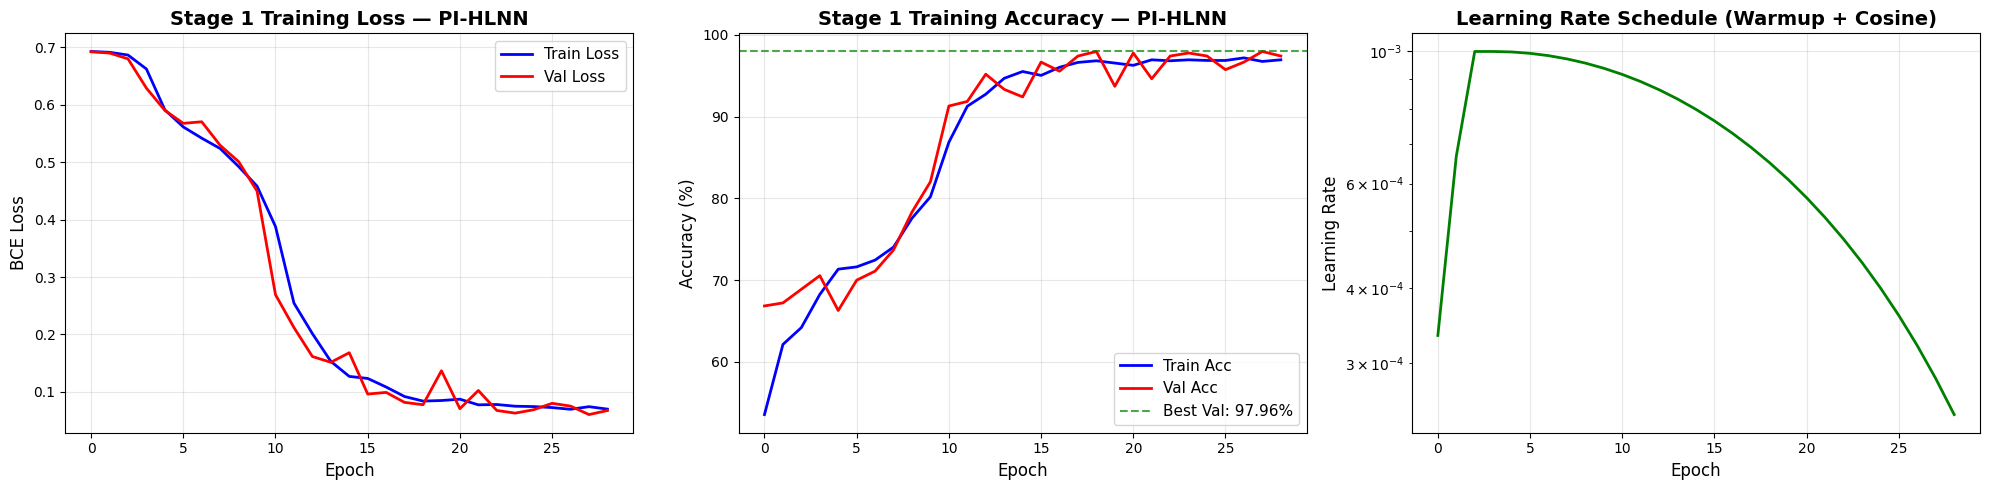

Training completed in 29 epochs
Final train loss: 0.0700, Final val loss: 0.0676
Final train acc:  96.94%, Best val acc: 97.96%


In [20]:
# ==========================================
# STAGE 1 TRAINING CURVES
# ==========================================
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Loss curve
ax1 = axes[0]
ax1.plot(history['epoch'], history['train_loss'], 'b-', linewidth=2, label='Train Loss')
ax1.plot(history['epoch'], history['val_loss'], 'r-', linewidth=2, label='Val Loss')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('BCE Loss', fontsize=12)
ax1.set_title('Stage 1 Training Loss — PI-HLNN', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Accuracy curve
ax2 = axes[1]
ax2.plot(history['epoch'], [a*100 for a in history['train_acc']], 'b-', linewidth=2, label='Train Acc')
ax2.plot(history['epoch'], [a*100 for a in history['val_acc']], 'r-', linewidth=2, label='Val Acc')
ax2.axhline(y=best_val_acc_s1*100, color='green', linestyle='--', alpha=0.7, label=f'Best Val: {best_val_acc_s1*100:.2f}%')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Stage 1 Training Accuracy — PI-HLNN', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# Learning rate schedule
ax3 = axes[2]
ax3.plot(history['epoch'], history['lr'], 'g-', linewidth=2)
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Learning Rate', fontsize=12)
ax3.set_title('Learning Rate Schedule (Warmup + Cosine)', fontsize=14, fontweight='bold')
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'Training completed in {len(history["epoch"])} epochs')
print(f'Final train loss: {history["train_loss"][-1]:.4f}, Final val loss: {history["val_loss"][-1]:.4f}')
print(f'Final train acc:  {history["train_acc"][-1]*100:.2f}%, Best val acc: {best_val_acc_s1*100:.2f}%')

In [21]:
# ==========================================
# STAGE 2 TRAINING: RF Bounce Classifier (NLOS only)
# Label: bounce_path_idx − los_path_idx > BOUNCE_SEP_THRESHOLD
#   0 = short bounce (14m + 7.79m scenarios, small NLOS bias)
#   1 = long  bounce (10.77m scenario, large NLOS bias)
# Input: 64-dim LNN embeddings from frozen Stage 1 PI-HLNN encoder
# ==========================================
print('STAGE 2: Training RF Bounce Classifier on NLOS subset of train set...')
print('='*60)

# Filter NLOS subsets
nlos_train = train_df[train_df['Label'] == 1].reset_index(drop=True)
nlos_val   = val_df[val_df['Label']   == 1].reset_index(drop=True)

# Ground-truth labels from geometry-derived bounce separation
y_train_s2 = get_bounce_labels(nlos_train)
y_val_s2   = get_bounce_labels(nlos_val)

print(f'  Train NLOS: {len(nlos_train)} — short={int((y_train_s2==0).sum())}, long={int((y_train_s2==1).sum())}')
print(f'  Val NLOS:   {len(nlos_val)} — short={int((y_val_s2==0).sum())}, long={int((y_val_s2==1).sum())}')
print(f'  Label basis: bounce_path_idx − los_path_idx > {BOUNCE_SEP_THRESHOLD} idx (physics GT)')

# Extract LNN embeddings (64-dim) from frozen Stage 1 encoder
print(f'\n  Extracting {EMBEDDING_DIM}-dim LNN embeddings from frozen Stage 1...')
X_train_s2 = extract_lnn_embeddings(model_s1, nlos_train)
X_val_s2   = extract_lnn_embeddings(model_s1, nlos_val)
print(f'  Train embeddings: {X_train_s2.shape}')
print(f'  Val embeddings:   {X_val_s2.shape}')

# Train Random Forest on LNN embeddings (scale-invariant, no scaling needed)
model_s2 = RandomForestClassifier(
    n_estimators=200, max_depth=None,
    min_samples_split=5, min_samples_leaf=2,
    class_weight='balanced', random_state=SEED, n_jobs=-1,
)
model_s2.fit(X_train_s2, y_train_s2)

train_acc_s2    = (model_s2.predict(X_train_s2) == y_train_s2).mean()
val_acc_s2      = (model_s2.predict(X_val_s2)   == y_val_s2).mean()
best_val_acc_s2 = val_acc_s2

print(f'\n  Input: {EMBEDDING_DIM}-dim LNN embeddings (frozen Stage 1 PI-HLNN)')
print(f'  Train Accuracy: {100*train_acc_s2:.2f}%')
print(f'  Val Accuracy:   {100*val_acc_s2:.2f}%')


STAGE 2: Training RF Bounce Classifier on NLOS subset of train set...
  Train NLOS: 1260 — short=821, long=439
  Val NLOS:   270 — short=187, long=83
  Label basis: bounce_path_idx − los_path_idx > 21.4 idx (physics GT)

  Extracting 64-dim LNN embeddings from frozen Stage 1...
  Train embeddings: (1260, 64)
  Val embeddings:   (270, 64)

  Input: 64-dim LNN embeddings (frozen Stage 1 PI-HLNN)
  Train Accuracy: 99.68%
  Val Accuracy:   96.67%


In [26]:
# ==========================================
# STAGE 3 TRAINING: RF NLOS Bias Predictor (all NLOS)
# Target: d_bounce − d_direct per row (ground truth from dataset columns)
# Input:  64-dim LNN embedding  +  1-dim Stage 2 bounce class  =  65-dim
#
# Using GT Stage 2 labels during training for clean cascade supervision.
# At test time, Stage 2 predictions are used instead (realistic evaluation).
# ==========================================
print('STAGE 3: Training RF Bias Predictor on all NLOS...')
print('='*60)

# Per-row ground-truth bias and metadata from dataset columns
src_train, dist_train, bias_train, dd_train, db_train = get_nlos_info(nlos_train)
src_val,   dist_val,   bias_val,   dd_val,   db_val   = get_nlos_info(nlos_val)

y_train_s3 = np.array(bias_train, dtype=np.float32)   # d_bounce − d_direct per row
y_val_s3   = np.array(bias_val,   dtype=np.float32)

# Augment LNN embeddings with GT Stage 2 bounce class (65-dim input)
X_train_s3 = np.column_stack([X_train_s2, y_train_s2.reshape(-1, 1)])
X_val_s3   = np.column_stack([X_val_s2,   y_val_s2.reshape(-1, 1)])

print(f'  Train NLOS: {len(nlos_train)}, Val NLOS: {len(nlos_val)}')
print(f'  Target: d_bounce − d_direct per row (GT from dataset)')
print(f'  Train bias range: [{y_train_s3.min():.3f}, {y_train_s3.max():.3f}] m')
print(f'  Input dim: {X_train_s3.shape[1]}  (64-dim LNN emb + 1-dim bounce class)')

model_s3 = RandomForestRegressor(
    n_estimators=200, max_depth=None,
    min_samples_split=5, min_samples_leaf=2,
    random_state=SEED, n_jobs=-1,
)
model_s3.fit(X_train_s3, y_train_s3)

train_mae_s3    = mean_absolute_error(y_train_s3, model_s3.predict(X_train_s3))
val_preds_s3    = model_s3.predict(X_val_s3)
best_val_mae_s3 = mean_absolute_error(y_val_s3, val_preds_s3)

print(f'\n  Input: {X_train_s3.shape[1]}-dim (LNN embeddings + bounce class)')
print(f'  Train MAE: {train_mae_s3:.4f}m')
print(f'  Val MAE:   {best_val_mae_s3:.4f}m')


STAGE 3: Training RF Bias Predictor on all NLOS...
  Train NLOS: 1260, Val NLOS: 270
  Target: d_bounce − d_direct per row (GT from dataset)
  Train bias range: [2.800, 8.889] m
  Input dim: 65  (64-dim LNN emb + 1-dim bounce class)

  Input: 65-dim (LNN embeddings + bounce class)
  Train MAE: 0.0103m
  Val MAE:   0.0198m


---
## Section 5: End-to-End Pipeline Test on Unseen 15% Test Set

The test set has **never** been seen during training or validation.  
Run the full chained pipeline:
```
CIR → Stage 1 (LOS/NLOS?) → Stage 2 (bounce type?) → Stage 3 (bias) → d_corrected
```

In [27]:
# ==========================================
# END-TO-END PIPELINE TEST
# ==========================================
print('END-TO-END PIPELINE TEST ON UNSEEN TEST SET')
print('='*70)
print(f'Test set: {len(test_df)} samples (completely unseen)\n')

# --- Stage 1: LOS/NLOS Classification ---
X_test_s1, y_test_s1 = preprocess_stage1(test_df)
X_t1 = torch.tensor(X_test_s1).to(device)

model_s1.eval()
with torch.no_grad():
    s1_probs, _, _ = model_s1(X_t1)
    s1_preds = (s1_probs > 0.5).float().cpu().numpy().flatten()

s1_true = y_test_s1
s1_acc  = (s1_preds == s1_true).mean()
print(f'STAGE 1 (LOS/NLOS Classification):')
print(f'  Accuracy: {100*s1_acc:.2f}%')
print(f'  Predicted LOS: {int((s1_preds==0).sum())}, NLOS: {int((s1_preds==1).sum())}')
print(f'  Actual    LOS: {int((s1_true==0).sum())}, NLOS: {int((s1_true==1).sum())}\n')

# --- Stage 2: Bounce Classification (on predicted NLOS) ---
nlos_mask_pred = s1_preds == 1
nlos_test_df   = test_df[nlos_mask_pred].reset_index(drop=True)

# Ground-truth Stage 2 labels (geometry-derived, for evaluation only)
y_test_s2_true = get_bounce_labels(nlos_test_df)

# Extract LNN embeddings for predicted-NLOS test samples
X_test_s2 = extract_lnn_embeddings(model_s1, nlos_test_df)
s2_preds  = model_s2.predict(X_test_s2)

s2_acc = (s2_preds == y_test_s2_true).mean()
print(f'STAGE 2 (Bounce Classification — on Stage 1 NLOS predictions):')
print(f'  Input: {EMBEDDING_DIM}-dim LNN embeddings')
print(f'  Samples entering Stage 2: {len(nlos_test_df)}')
print(f'  Accuracy: {100*s2_acc:.2f}%')
print(f'  Predicted short: {int((s2_preds==0).sum())}, long: {int((s2_preds==1).sum())}')
print(f'  Actual    short: {int((y_test_s2_true==0).sum())}, long: {int((y_test_s2_true==1).sum())}\n')

# --- Stage 3: Bias Prediction (all NLOS, Stage 2 predictions as feature) ---
# Use Stage 2 predictions (not GT) — realistic cascade evaluation
X_test_s3 = np.column_stack([X_test_s2, s2_preds.reshape(-1, 1)])   # (N, 65)
s3_preds  = model_s3.predict(X_test_s3)

src_test, dist_test, bias_test, dd_test, db_test = get_nlos_info(nlos_test_df)
y_test_s3 = np.array(bias_test, dtype=np.float32)

results_df = pd.DataFrame({
    'source_file':     src_test,
    'group':           [get_distance_group(f) for f in src_test],
    'd_uwb':           dist_test,
    'd_direct':        dd_test,
    'd_bounce':        db_test,
    'actual_bias':     bias_test,
    'ml_bias':         s3_preds,
    'bounce_pred':     s2_preds,
    'bounce_true':     y_test_s2_true,
})

# Drop LOS misclassifications: Stage 1 errors that land here have d_bounce=NaN (no reflector)
n_before = len(results_df)
results_df = results_df.dropna(subset=['actual_bias', 'd_bounce', 'd_direct']).reset_index(drop=True)
n_dropped  = n_before - len(results_df)
if n_dropped > 0:
    print(f'  Note: {n_dropped} Stage 1 misclassification(s) dropped (LOS→NLOS, no d_bounce GT)\n')

results_df['d_corrected']      = results_df['d_uwb'] - results_df['ml_bias']
results_df['bias_error']       = (results_df['ml_bias'] - results_df['actual_bias']).abs()
results_df['correction_error'] = (results_df['d_corrected'] - results_df['d_direct']).abs()

test_mae  = results_df['bias_error'].mean()
test_rmse = np.sqrt((results_df['bias_error']**2).mean())

print(f'STAGE 3 (Bias Prediction — all NLOS, Stage 2 bounce class as feature):')
print(f'  Input: {EMBEDDING_DIM+1}-dim  (64-dim LNN emb + 1-dim bounce class from Stage 2)')
print(f'  Samples: {len(results_df)}')
print(f'  Bias MAE:  {test_mae:.4f}m')
print(f'  Bias RMSE: {test_rmse:.4f}m')
print(f'  Correction MAE: {results_df["correction_error"].mean():.4f}m')

print(f'\n{"="*70}')
print(f'END-TO-END PIPELINE SUMMARY (on unseen test set)')
print(f'{"="*70}')
print(f'  Stage 1 (LOS/NLOS):        {100*s1_acc:.2f}% accuracy')
print(f'  Stage 2 (bounce type):     {100*s2_acc:.2f}% accuracy')
print(f'  Stage 3 (bias prediction): MAE = {test_mae:.4f}m')
print(f'  Distance correction:       MAE = {results_df["correction_error"].mean():.4f}m')
print(f'\n  Pipeline flow: {len(test_df)} total → {int(nlos_mask_pred.sum())} NLOS → {len(results_df)} valid bias-corrected')


END-TO-END PIPELINE TEST ON UNSEEN TEST SET
Test set: 540 samples (completely unseen)

STAGE 1 (LOS/NLOS Classification):
  Accuracy: 97.04%
  Predicted LOS: 272, NLOS: 268
  Actual    LOS: 270, NLOS: 270

STAGE 2 (Bounce Classification — on Stage 1 NLOS predictions):
  Input: 64-dim LNN embeddings
  Samples entering Stage 2: 268
  Accuracy: 97.01%
  Predicted short: 191, long: 77
  Actual    short: 193, long: 75

  Note: 7 Stage 1 misclassification(s) dropped (LOS→NLOS, no d_bounce GT)

STAGE 3 (Bias Prediction — all NLOS, Stage 2 bounce class as feature):
  Input: 65-dim  (64-dim LNN emb + 1-dim bounce class from Stage 2)
  Samples: 261
  Bias MAE:  0.1805m
  Bias RMSE: 0.9180m
  Correction MAE: 3.5806m

END-TO-END PIPELINE SUMMARY (on unseen test set)
  Stage 1 (LOS/NLOS):        97.04% accuracy
  Stage 2 (bounce type):     97.01% accuracy
  Stage 3 (bias prediction): MAE = 0.1805m
  Distance correction:       MAE = 3.5806m

  Pipeline flow: 540 total → 268 NLOS → 261 valid bias-cor

---
## Section 6: Test Set Visualization

Comprehensive plots showing pipeline performance on the unseen test set.

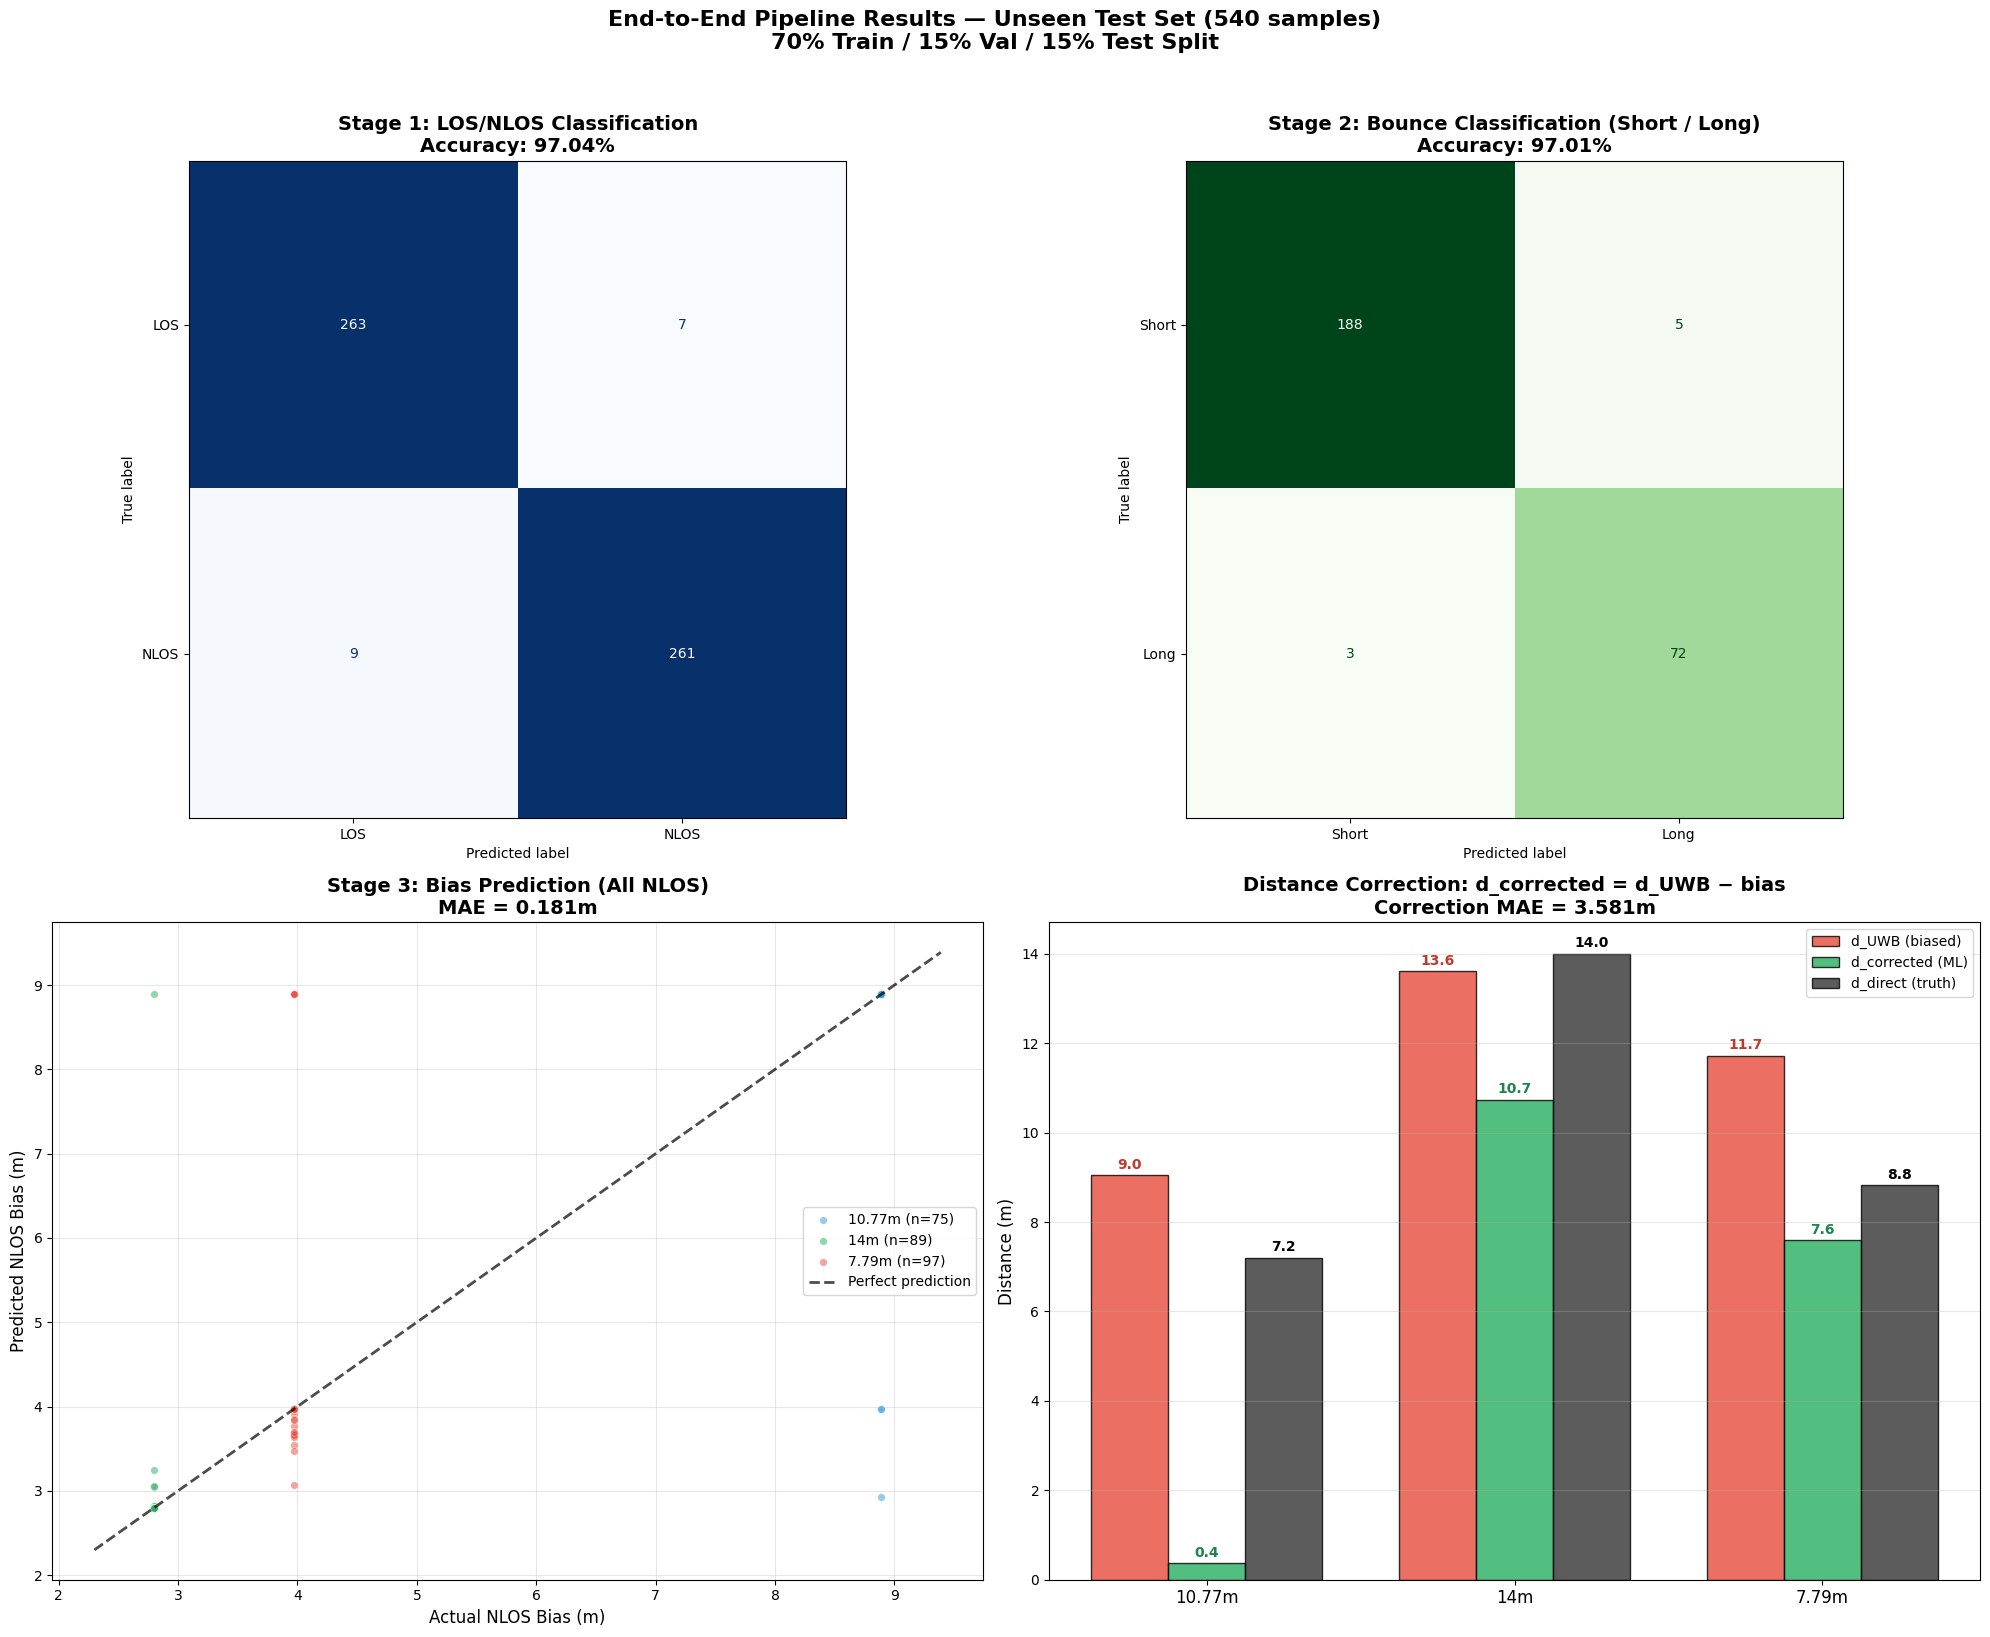

In [28]:
# ==========================================
# VISUALIZATION: 4-PANEL RESULTS
# ==========================================
fig, axs = plt.subplots(2, 2, figsize=(20, 16))
plt.subplots_adjust(hspace=0.35, wspace=0.3)

colors_map = {'7.79m': '#e74c3c', '10.77m': '#3498db', '14m': '#27ae60'}

# --- Panel 1: Stage 1 Confusion Matrix ---
ax = axs[0, 0]
cm1 = confusion_matrix(s1_true, s1_preds)
disp1 = ConfusionMatrixDisplay(cm1, display_labels=['LOS', 'NLOS'])
disp1.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title(f'Stage 1: LOS/NLOS Classification\nAccuracy: {100*s1_acc:.2f}%',
             fontsize=14, fontweight='bold')

# --- Panel 2: Stage 2 Confusion Matrix ---
ax = axs[0, 1]
cm2 = confusion_matrix(y_test_s2_true, s2_preds)
disp2 = ConfusionMatrixDisplay(cm2, display_labels=['Short', 'Long'])
disp2.plot(ax=ax, cmap='Greens', colorbar=False)
ax.set_title(f'Stage 2: Bounce Classification (Short / Long)\nAccuracy: {100*s2_acc:.2f}%',
             fontsize=14, fontweight='bold')

# --- Panel 3: Stage 3 Actual vs Predicted Bias ---
ax = axs[1, 0]
for grp in sorted(results_df['group'].dropna().unique()):
    mask = results_df['group'] == grp
    sub  = results_df[mask]
    if len(sub) > 0:
        ax.scatter(sub['actual_bias'], sub['ml_bias'], alpha=0.5, s=30,
                   color=colors_map.get(grp, '#888'),
                   label=f'{grp} (n={len(sub)})',
                   edgecolors='white', linewidth=0.5)

all_bias = np.concatenate([results_df['actual_bias'].values, results_df['ml_bias'].values])
lims = [all_bias.min() - 0.5, all_bias.max() + 0.5]
ax.plot(lims, lims, 'k--', lw=2, alpha=0.7, label='Perfect prediction')
ax.set_xlabel('Actual NLOS Bias (m)', fontsize=12)
ax.set_ylabel('Predicted NLOS Bias (m)', fontsize=12)
ax.set_title(f'Stage 3: Bias Prediction (All NLOS)\nMAE = {test_mae:.3f}m',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# --- Panel 4: Distance Correction ---
ax = axs[1, 1]
groups_sorted = sorted(results_df['group'].dropna().unique())
x_pos = np.arange(len(groups_sorted))
width = 0.25

d_uwb_vals, d_corr_vals, d_direct_vals = [], [], []
for grp in groups_sorted:
    sub = results_df[results_df['group'] == grp]
    d_uwb_vals.append(sub['d_uwb'].mean()      if len(sub) > 0 else 0)
    d_corr_vals.append(sub['d_corrected'].mean() if len(sub) > 0 else 0)
    d_direct_vals.append(sub['d_direct'].mean()  if len(sub) > 0 else 0)

ax.bar(x_pos - width, d_uwb_vals,    width, label='d_UWB (biased)',   color='#e74c3c', alpha=0.8, edgecolor='black')
ax.bar(x_pos,         d_corr_vals,   width, label='d_corrected (ML)', color='#27ae60', alpha=0.8, edgecolor='black')
ax.bar(x_pos + width, d_direct_vals, width, label='d_direct (truth)', color='#333333', alpha=0.8, edgecolor='black')

for i, (u, c, d) in enumerate(zip(d_uwb_vals, d_corr_vals, d_direct_vals)):
    if u > 0:
        ax.text(i - width, u + 0.15, f'{u:.1f}', ha='center', fontsize=10, fontweight='bold', color='#c0392b')
        ax.text(i,         c + 0.15, f'{c:.1f}', ha='center', fontsize=10, fontweight='bold', color='#1e8449')
        ax.text(i + width, d + 0.15, f'{d:.1f}', ha='center', fontsize=10, fontweight='bold')

ax.set_xticks(x_pos)
ax.set_xticklabels(groups_sorted, fontsize=12)
ax.set_ylabel('Distance (m)', fontsize=12)
ax.set_title(f'Distance Correction: d_corrected = d_UWB − bias\nCorrection MAE = {results_df["correction_error"].mean():.3f}m',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

fig.suptitle(
    f'End-to-End Pipeline Results — Unseen Test Set ({len(test_df)} samples)\n'
    f'70% Train / 15% Val / 15% Test Split',
    fontsize=16, fontweight='bold', y=1.02
)
plt.tight_layout()
plt.show()


In [25]:
# ==========================================
# BOUNCE DISTANCE BENCHMARK vs Xu Xueli (2024)
# predicted_d_bounce = d_direct + ml_bias
# ==========================================
results_df['actual_d_bounce']    = results_df['d_bounce']
results_df['predicted_d_bounce'] = results_df['d_direct'] + results_df['ml_bias']

our_db_mae  = mean_absolute_error(results_df['actual_d_bounce'], results_df['predicted_d_bounce'])
our_db_rmse = np.sqrt(mean_squared_error(results_df['actual_d_bounce'], results_df['predicted_d_bounce']))
our_db_r2   = r2_score(results_df['actual_d_bounce'], results_df['predicted_d_bounce'])

# Xu Xueli's reported metrics
xu_mae, xu_rmse, xu_r2 = 0.34594, 0.60008, 0.61868

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Scatter: actual vs predicted bounce distance
ax = axs[0]
for grp in sorted(results_df['group'].dropna().unique()):
    sub = results_df[results_df['group'] == grp]
    if len(sub) > 0:
        ax.scatter(sub['actual_d_bounce'], sub['predicted_d_bounce'],
                   alpha=0.5, s=40, color=colors_map.get(grp, '#888'),
                   edgecolors='white', linewidth=0.5,
                   label=f'{grp} (n={len(sub)})')

all_db = np.concatenate([results_df['actual_d_bounce'].values, results_df['predicted_d_bounce'].values])
lims   = [all_db.min() - 1, all_db.max() + 1]
ax.plot(lims, lims, 'k--', lw=2, alpha=0.7)
ax.set_xlabel('Actual 1-Bounce Distance (m)', fontsize=13)
ax.set_ylabel('Predicted 1-Bounce Distance (m)', fontsize=13)
ax.set_title(f'Ours — Unseen Test Set\nMAE={our_db_mae:.3f}m  R²={our_db_r2:.3f}',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim(lims); ax.set_ylim(lims)
ax.set_aspect('equal')

# Bar: metrics comparison
ax = axs[1]
labels = ['MAE (m)', 'RMSE (m)', 'R²']
xu_v   = [xu_mae, xu_rmse, xu_r2]
our_v  = [our_db_mae, our_db_rmse, our_db_r2]
x = np.arange(len(labels))
w = 0.35
ax.bar(x - w/2, xu_v,  w, label='Xu Xueli (2024)\nEncoder + RF', color='#e74c3c', alpha=0.8, edgecolor='black')
ax.bar(x + w/2, our_v, w, label='Ours (Test Set)\nLNN Embeddings + RF', color='#27ae60', alpha=0.8, edgecolor='black')
for bar, val in zip(ax.containers[0], xu_v):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{val:.3f}', ha='center', fontsize=12, fontweight='bold', color='#c0392b')
for bar, val in zip(ax.containers[1], our_v):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{val:.3f}', ha='center', fontsize=12, fontweight='bold', color='#1e8449')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.set_title('Bounce Distance: Ours vs Xu Xueli (2024)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

fig.suptitle('1-Bounce Distance Prediction — Unseen Test Set vs Prior Work',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f'\nBounce Distance Benchmark (Unseen Test Set):')
print(f'  {"Metric":<8} | {"Xu Xueli":<12} | {"Ours":<12} | Improvement')
print(f'  {"-"*50}')
print(f'  {"MAE":<8} | {xu_mae:<11.3f}m | {our_db_mae:<11.3f}m | {xu_mae/our_db_mae:.1f}x lower')
print(f'  {"RMSE":<8} | {xu_rmse:<11.3f}m | {our_db_rmse:<11.3f}m | {xu_rmse/our_db_rmse:.1f}x lower')
print(f'  {"R²":<8} | {xu_r2:<12.3f} | {our_db_r2:<12.3f} | +{our_db_r2 - xu_r2:.3f}')


ValueError: Input contains NaN.

---
## Section 7: Save Production Models

Save the models trained on the 70% train split for deployment.

In [ ]:
# ==========================================
# SAVE PRODUCTION MODELS
# ==========================================
# Stage 1: PyTorch model
torch.save(model_s1.state_dict(), 'prod_stage1_pi_hlnn.pt')

# Stages 2 & 3: sklearn Random Forest
joblib.dump(model_s2, 'prod_stage2_bounce_rf.joblib')
joblib.dump(model_s3, 'prod_stage3_bias_rf.joblib')

# Pipeline config
torch.save({
    'stage1_config':       S1_CONFIG,
    'embedding_dim':       EMBEDDING_DIM,
    'embedding_names':     EMBEDDING_NAMES,
    'bounce_sep_threshold': BOUNCE_SEP_THRESHOLD,
    'note': (
        'Stage 2 label: bounce_path_idx - los_path_idx > BOUNCE_SEP_THRESHOLD (physics GT). '
        'Stage 3 input: 65-dim (64-dim LNN emb + 1-dim bounce class from Stage 2). '
        'Stage 3 target: d_bounce - d_direct per row.'
    ),
}, 'prod_pipeline_config.pt')

print('Saved production models:')
print('  prod_stage1_pi_hlnn.pt       (PyTorch)')
print('  prod_stage2_bounce_rf.joblib (sklearn RF)')
print('  prod_stage3_bias_rf.joblib   (sklearn RF)')
print('  prod_pipeline_config.pt      (config dict)')


In [ ]:
# ==========================================
# FINAL SUMMARY
# ==========================================
print('='*70)
print('MULTI-MODEL PIPELINE -- FINAL RESULTS')
print('='*70)
print(f'\nData Split: 70/15/15 (Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)})')
print(f'\nPipeline Architecture:')
print(f'  Stage 1: PI-HLNN (Liquid Neural Network)    -- {sum(p.numel() for p in model_s1.parameters()):,} params')
print(f'  Stage 2: Random Forest Bounce Classifier     -- {model_s2.n_estimators} trees, {EMBEDDING_DIM}-dim LNN embeddings')
print(f'           Input: Frozen Stage 1 PI-HLNN encoder -> {EMBEDDING_DIM}-dim h_pooled')
print(f'  Stage 3: Random Forest Bias Regressor        -- {model_s3.n_estimators} trees, {EMBEDDING_DIM}-dim LNN embeddings')
print(f'           Input: Frozen Stage 1 PI-HLNN encoder -> {EMBEDDING_DIM}-dim h_pooled')
print(f'\nResults on Unseen Test Set ({len(test_df)} samples):')
print(f'  Stage 1 (LOS/NLOS):      {100*s1_acc:.2f}% accuracy')
print(f'  Stage 2 (Bounce type):   {100*s2_acc:.2f}% accuracy')
print(f'  Stage 3 (Bias):          MAE = {test_mae:.4f}m')
print(f'  Distance correction:     MAE = {results_df["correction_error"].mean():.4f}m')
print(f'\nBenchmark vs Xu Xueli (2024):')
print(f'  Bounce distance MAE: {our_db_mae:.3f}m (ours) vs {xu_mae:.3f}m (Xu Xueli)')
print(f'  Bounce distance R2:  {our_db_r2:.3f} (ours) vs {xu_r2:.3f} (Xu Xueli)')
print(f'\nPipeline flow on test set:')
print(f'  {len(test_df)} total')
print(f'  -> {int(nlos_mask_pred.sum())} classified as NLOS (Stage 1)')
print(f'  -> {int(single_mask_pred.sum())} classified as single-bounce (Stage 2)')
print(f'  -> {len(results_df)} bias predicted + distance corrected (Stage 3)')
print(f'\nAt inference: d_corrected = d_UWB - predicted_bias')

MULTI-MODEL PIPELINE -- FINAL RESULTS

Data Split: 70/15/15 (Train=2520, Val=540, Test=540)

Pipeline Architecture:
  Stage 1: PI-HLNN (Liquid Neural Network)    -- 16,963 params
  Stage 2: Random Forest Bounce Classifier     -- 200 trees, 64-dim LNN embeddings
           Input: Frozen Stage 1 PI-HLNN encoder -> 64-dim h_pooled
  Stage 3: Random Forest Bias Regressor        -- 200 trees, 64-dim LNN embeddings
           Input: Frozen Stage 1 PI-HLNN encoder -> 64-dim h_pooled

Results on Unseen Test Set (540 samples):
  Stage 1 (LOS/NLOS):      97.04% accuracy
  Stage 2 (Bounce type):   89.18% accuracy
  Stage 3 (Bias):          MAE = 2.5578m
  Distance correction:     MAE = 2.6022m

Benchmark vs Xu Xueli (2024):
  Bounce distance MAE: 2.556m (ours) vs 0.346m (Xu Xueli)
  Bounce distance R2:  -2.066 (ours) vs 0.619 (Xu Xueli)

Pipeline flow on test set:
  540 total
  -> 268 classified as NLOS (Stage 1)
  -> 117 classified as single-bounce (Stage 2)
  -> 117 bias predicted + distance co